In [3]:
!cp -r drive/MyDrive/data .

# Data

In [16]:
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import torch.optim as optim
from torch.autograd import Variable
import datetime
import umap.umap_ as umap
import IPython
from torchsummaryX import summary

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
device = 'cuda:0'

In [8]:
df = pd.read_csv('data/bird_songs_metadata.csv')
df.head()
df.filename.iloc[1]

'557838-1.wav'

In [9]:
species = ['migratorius', 'polyglottos', 'cardinalis', 'bewickii','melodia']
species
i = 0
sp = {}
ps = {}
for specie in species:
    sp[specie] = i
    ps[i] = specie
    i += 1

In [10]:
species

['migratorius', 'polyglottos', 'cardinalis', 'bewickii', 'melodia']

In [11]:
len(species)

5

In [42]:
class AudioDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        waveform, _ = librosa.load(os.path.join(self.root_dir, self.df.filename.iloc[index]))
        spec = np.log1p(np.abs(librosa.stft(waveform)))
        return torch.Tensor([spec]).cuda(), sp[self.df.species.iloc[index]]

In [43]:
dataset = AudioDataset('data/bird_songs_metadata.csv', 'data/wavfiles/')
dataset[10][0].shape

torch.Size([1, 1025, 130])

# Model

In [97]:
class Model(nn.Module):
    def __init__(self, dropout=1.0):
        super().__init__()
        layers = [
            self._block(1, 32),
            self._block(32, 64),
            self._block(64, 128),
            self._block(128, 256)
        ]
        self.encoder = nn.Sequential(*layers)
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.dropout = nn.Dropout(p=dropout)
        self.out = nn.Linear(in_features=128, out_features=5)
    
    def _block(self, dim_in, dim_out, kernel_size=(3,3), stride=(2, 2)):
        layers = [
           nn.Conv2d(dim_in, dim_out, kernel_size, stride=stride), 
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.interpolate(x, size=(365,365))
        x = self.encoder(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        if self.training:
          x = self.dropout(x)
        x = self.out(x)
        return x
    
    def encode(self, x):
        x = F.interpolate(x, size=(365,365))
        x = self.encoder(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        return x

model = Model(dropout=0.3)

In [89]:
summary(model, torch.ones(1, 1, 1025, 130))

                              Kernel Shape       Output Shape    Params  \
Layer                                                                     
0_encoder.0.Conv2d_0         [1, 32, 3, 3]  [1, 32, 182, 182]     320.0   
1_encoder.0.ReLU_1                       -  [1, 32, 182, 182]         -   
2_encoder.0.MaxPool2d_2                  -    [1, 32, 91, 91]         -   
3_encoder.1.Conv2d_0        [32, 64, 3, 3]    [1, 64, 45, 45]   18.496k   
4_encoder.1.ReLU_1                       -    [1, 64, 45, 45]         -   
5_encoder.1.MaxPool2d_2                  -    [1, 64, 22, 22]         -   
6_encoder.2.Conv2d_0       [64, 128, 3, 3]   [1, 128, 10, 10]   73.856k   
7_encoder.2.ReLU_1                       -   [1, 128, 10, 10]         -   
8_encoder.2.MaxPool2d_2                  -     [1, 128, 5, 5]         -   
9_encoder.3.Conv2d_0      [128, 256, 3, 3]     [1, 256, 2, 2]  295.168k   
10_encoder.3.ReLU_1                      -     [1, 256, 2, 2]         -   
11_encoder.3.MaxPool2d_2 

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.0.Conv2d_0,"[1, 32, 3, 3]","[1, 32, 182, 182]",320.0,9539712.0
1_encoder.0.ReLU_1,-,"[1, 32, 182, 182]",NaN,NaN
2_encoder.0.MaxPool2d_2,-,"[1, 32, 91, 91]",NaN,NaN
3_encoder.1.Conv2d_0,"[32, 64, 3, 3]","[1, 64, 45, 45]",18496.0,37324800.0
4_encoder.1.ReLU_1,-,"[1, 64, 45, 45]",NaN,NaN
5_encoder.1.MaxPool2d_2,-,"[1, 64, 22, 22]",NaN,NaN
6_encoder.2.Conv2d_0,"[64, 128, 3, 3]","[1, 128, 10, 10]",73856.0,7372800.0
7_encoder.2.ReLU_1,-,"[1, 128, 10, 10]",NaN,NaN
8_encoder.2.MaxPool2d_2,-,"[1, 128, 5, 5]",NaN,NaN


In [98]:
model.to(device)

Model(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=5, 

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion.to(device)

CrossEntropyLoss()

In [92]:
len(dataset)

5422

In [93]:
dataset[10][1]

3

In [101]:
best_vloss = 1_000_000

In [99]:
loss_per_epoch = []
vloss_per_epoch = []

In [102]:
for epoch in range(30):
    train_size = int(len(dataset) * 0.75)
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
  
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
    running_loss = 0.0
    model.train()
    epoch_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
                
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
                
        running_loss += loss.item()
        epoch_loss += loss.item()

        if i % 50 == 49:
            print(f"\tEpoch {epoch+1}, Batch {i+1}, loss: {(running_loss / 50):.3f}")
            running_loss = 0
    
    epoch_loss = epoch_loss / (i + 1)
    loss_per_epoch.append(epoch_loss)

    model.eval()
    val = 0.0
    for i, data in enumerate(val_loader, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val += loss.item()
    
    val = val / (i + 1)
    vloss_per_epoch.append(val)
    print(f'Epoch: {epoch + 1}, Loss: {epoch_loss:.3f}, Validation: {val:.3f}')
    if val < best_vloss:
      best_vloss = val
      timestamp = datetime.datetime.now().strftime('%Y-%m-%d')
      print(f'Saving drive/MyDrive/model/birds-{timestamp}...')
      torch.save(model.state_dict(), f'drive/MyDrive/model/birds-{timestamp}-{epoch + 1}')

	Epoch 1, Batch 50, loss: 1.239
	Epoch 1, Batch 100, loss: 0.944
Epoch: 1, Loss: 1.052, Validation: 0.822
Saving drive/MyDrive/model/birds-2023-05-16...
	Epoch 2, Batch 50, loss: 0.782
	Epoch 2, Batch 100, loss: 0.775
Epoch: 2, Loss: 0.760, Validation: 0.643
Saving drive/MyDrive/model/birds-2023-05-16...
	Epoch 3, Batch 50, loss: 0.633
	Epoch 3, Batch 100, loss: 0.584
Epoch: 3, Loss: 0.600, Validation: 0.500
Saving drive/MyDrive/model/birds-2023-05-16...
	Epoch 4, Batch 50, loss: 0.522
	Epoch 4, Batch 100, loss: 0.515
Epoch: 4, Loss: 0.503, Validation: 0.420
Saving drive/MyDrive/model/birds-2023-05-16...
	Epoch 5, Batch 50, loss: 0.373
	Epoch 5, Batch 100, loss: 0.388
Epoch: 5, Loss: 0.379, Validation: 0.343
Saving drive/MyDrive/model/birds-2023-05-16...
	Epoch 6, Batch 50, loss: 0.341
	Epoch 6, Batch 100, loss: 0.277
Epoch: 6, Loss: 0.306, Validation: 0.315
Saving drive/MyDrive/model/birds-2023-05-16...
	Epoch 7, Batch 50, loss: 0.312
	Epoch 7, Batch 100, loss: 0.265
Epoch: 7, Loss: 0

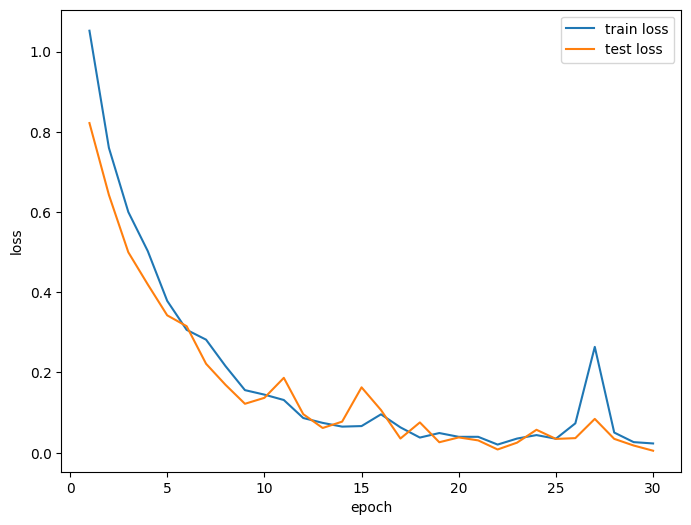

In [105]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, 31), loss_per_epoch, label='train loss')
plt.legend()
plt.plot(np.arange(1, 31), vloss_per_epoch, label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [106]:
model = Model()
model.to(device)
model.load_state_dict(torch.load('drive/MyDrive/model/birds-2023-05-16-30'))
model.eval()

Model(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=1.0, inplace=False)
  (out): Linear(in_features=128, out_features=5, 

# Embeddings

In [108]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [109]:
embeddings = []
files = []
for i in range(5):
  embeddings.append([])
  files.append([])
cnt = 0
for i, data in enumerate(data_loader):
  data, label = data
  data = data.to(device)
  label = label[0].item()
  with torch.no_grad():
    output = model(data).cpu()[0].numpy()
    class_probs = np.exp(output) / np.sum(np.exp(output), axis=-1, keepdims=True)
    pred = np.argmax(class_probs)
    if pred == label:
      cnt += 1
    if len(embeddings[label]) < 5:
      embeddings[label].append(model.encode(data)[0].cpu().numpy())
      files[label].append(df.filename.iloc[i])

In [110]:
print(f'Accuracy: {(cnt / len(dataset) * 100):.2f}%')

Accuracy: 99.89%


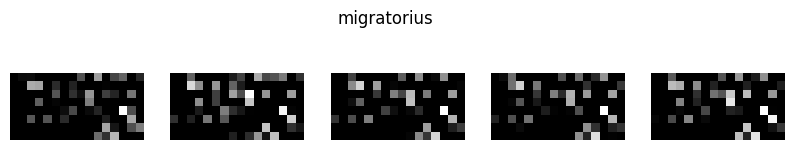

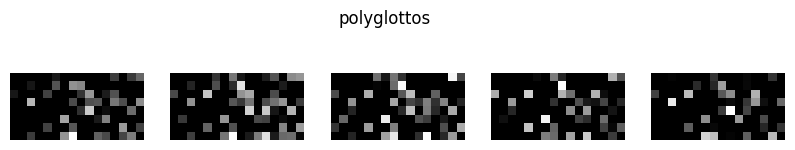

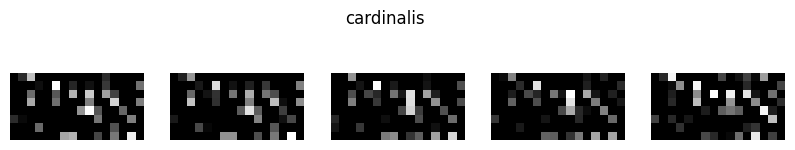

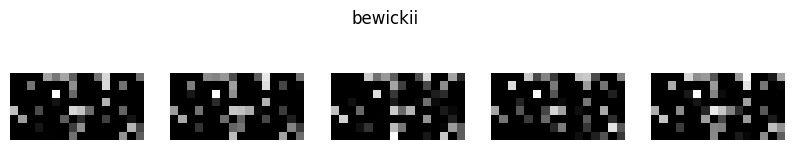

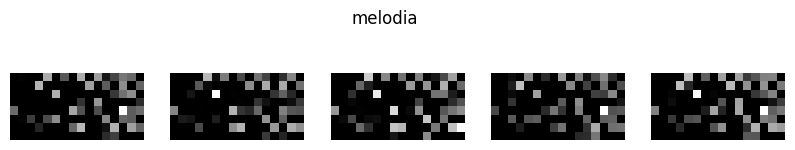

In [112]:
for j, bird_emb in enumerate(embeddings):
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))
  for i, emb in enumerate(bird_emb):
    img = np.reshape(emb, (8, 16))
    img = (img - np.min(img)) * (255 / (np.max(img) - np.min(img)))
    img = Image.fromarray(img.astype('uint8'), mode='L')
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
  fig.suptitle(ps[j])
  plt.show()

In [114]:
stack = []
for i, emb_bird in enumerate(embeddings):
  for j, emb in enumerate(emb_bird):
    stack.append(emb)
len(stack)

25

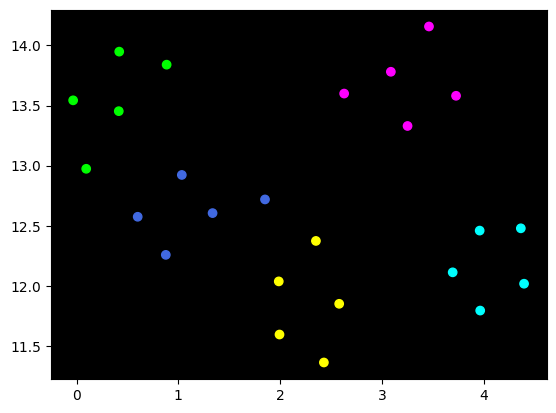

In [115]:
ax = plt.axes()
ax.set_facecolor('black')
embs = umap.UMAP(random_state=42).fit_transform(torch.Tensor(stack))
colors = []
colors = np.append(colors, np.full(shape=5,fill_value='yellow'))
colors = np.append(colors, np.full(shape=5,fill_value='lime'))
colors = np.append(colors, np.full(shape=5,fill_value='royalblue'))
colors = np.append(colors, np.full(shape=5,fill_value='magenta'))
colors = np.append(colors, np.full(shape=5,fill_value='cyan'))
plt.scatter(embs[:, 0], embs[:, 1], color=colors)
plt.show()

In [116]:
min_dist = 1_000_000
for i in range(4):
  for j in range(i + 1, 5):
    for p, x in enumerate(embeddings[i]):
      for q, y in enumerate(embeddings[j]):
        dist = np.linalg.norm(x - y)
        if dist < min_dist:
          min_dist = dist
          f1 = files[i][p]
          f2 = files[j][q]
          sp1 = ps[i]
          sp2 = ps[j]
print(min_dist, sp1, sp2, f1, f2)

16.812784 migratorius cardinalis 564545-6.wav 564312-4.wav


In [117]:
IPython.display.Audio(f'data/wavfiles/{f1}')

In [118]:
IPython.display.Audio(f'data/wavfiles/{f2}')